In [1]:
import cupy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import optuna

from joblib import dump,load
from datetime import timedelta
from xgboost import XGBClassifier,XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from imblearn.over_sampling import ADASYN,BorderlineSMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,precision_score,RocCurveDisplay
from sklearn.metrics import precision_recall_curve,auc,recall_score,PrecisionRecallDisplay
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Data Information**

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

(info taken from kaggle)

### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# Checking sum of Null's
df.isna().sum().sum()

0

In [5]:
# Number of duplicates
df.duplicated().sum()

1081

In [6]:
df[df.duplicated(keep=False)].head()  # To see all the duplicates, not just the first or last 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0


In [7]:
# Dropping all the duplicates
df.drop_duplicates(inplace=True)

In [8]:
df_melt = pd.melt(df,id_vars='Class',value_vars=[col for col in df.columns[1:-1]])
df_melt

,Class,variable,value
0,0,V1,-1.359807
1,0,V1,1.191857
2,0,V1,-1.358354
3,0,V1,-0.966272
4,0,V1,-1.158233
...,...,...,...
8228049,0,Amount,0.770000
8228050,0,Amount,24.790000
8228051,0,Amount,67.880000
8228052,0,Amount,10.000000


Let's examine the distribution of all variables between the Fraudulent and Authentic classes. We'll use histograms with density statistics instead of the default count values. This approach represents the probability density function (PDF) of the data, making it useful for comparing the shapes and distributions of different datasets or subsets of data, regardless of their sample sizes.

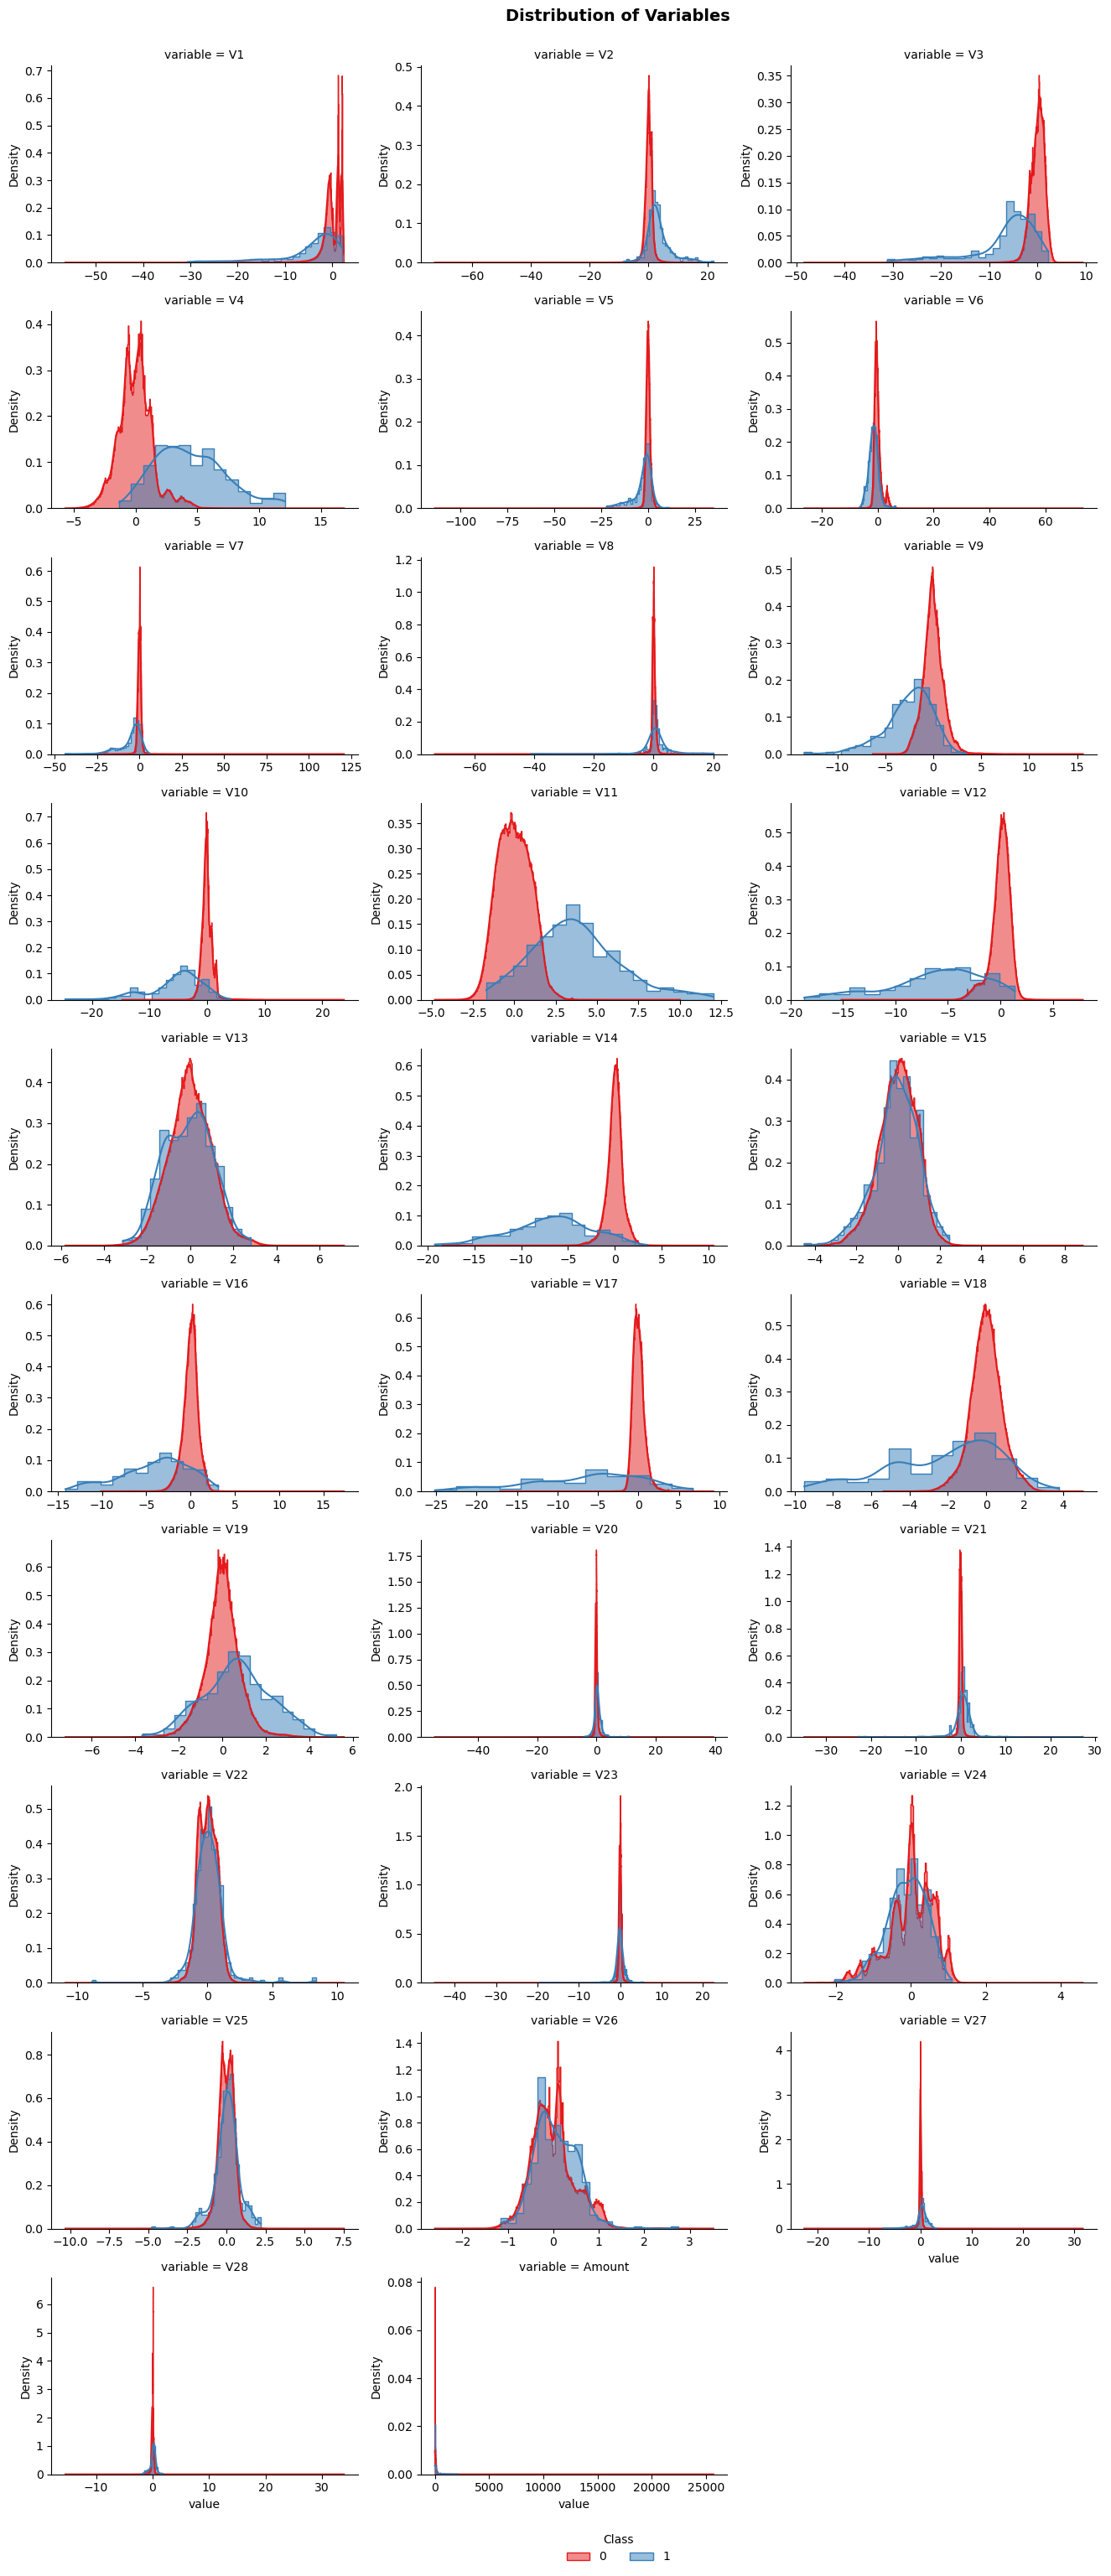

In [9]:
hist_fig = sb.FacetGrid(df_melt, col='variable', col_wrap=3, sharex=False, sharey=False, hue='Class', palette='Set1', aspect=1.5)
hist_fig.map_dataframe(sb.histplot, x='value', bins='fd', element='step', stat='density', kde=True)
hist_fig.figure.suptitle('Distribution of Variables', fontweight='bold', y=1, fontsize=14)
hist_fig.add_legend(title='Class', bbox_to_anchor=(0.5, -0.02), ncol=2, loc='lower center')
hist_fig.tight_layout();

> Lets look at the time feature more closely.

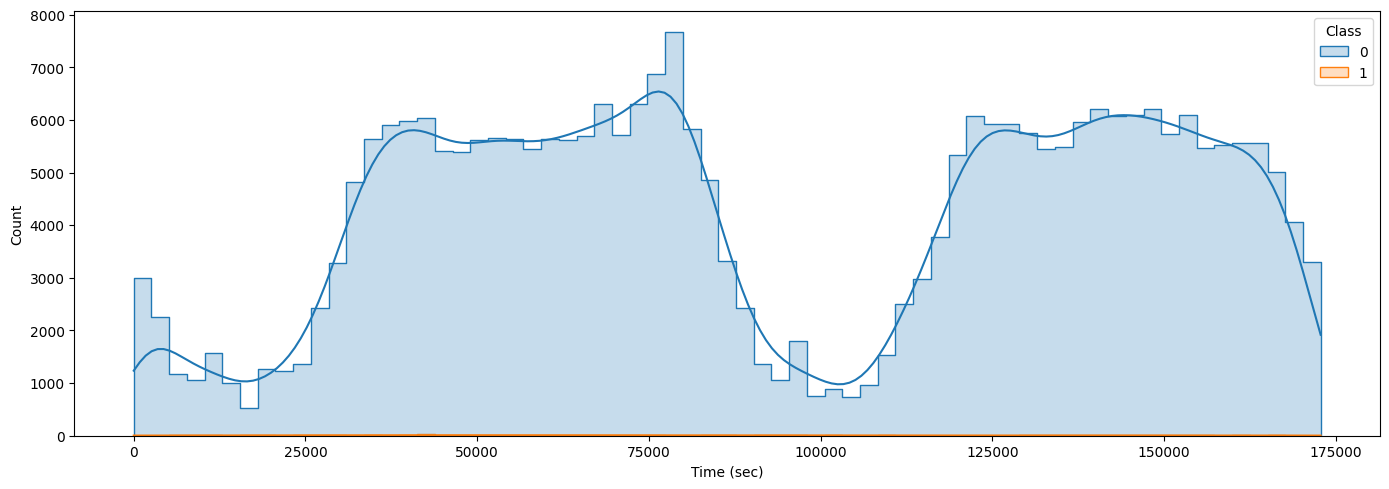

In [10]:
plt.figure(figsize=(14,5))
sb.histplot(df,x='Time',hue='Class',kde=True,element='step')
plt.xlabel('Time (sec)')
plt.tight_layout()

> Currently, time is given in seconds from the first transaction in the dataset to the last transaction in the dataset. We will convert this to HH:MM:SS format and split it into three columns. This could enhance the model's discriminative power, especially if fraudulent transactions tend to occur at specific times.

In [11]:
df['HH:MM:SS'] = df['Time'].apply(lambda X: timedelta(seconds=X))
# The apply function applies timedelta() and converts the time in seconds to days HH:MM:SS
df['HH:MM:SS'].tail()

284802   1 days 23:59:46
284803   1 days 23:59:47
284804   1 days 23:59:48
284805   1 days 23:59:48
284806   1 days 23:59:52
Name: HH:MM:SS, dtype: timedelta64[ns]

We'll remove the day component from the output since it shows very little variation (only 0 and 1), which won't be very useful for the training algorithm.

In [12]:
# Extracting the components to new time features
df[['hours','minutes','seconds']] = df['HH:MM:SS'].dt.components[['hours','minutes','seconds']]
# Dropping old time features
df.drop(['HH:MM:SS','Time'],axis=1,inplace=True)
# Reindexing
col_order = ['hours','minutes','seconds'] + list(df.columns[:-3])
df = df[col_order]
df.head()

,hours,minutes,seconds,V1,V2,V3,V4,V5,V6,V7,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,0,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0,0,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0,0,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0,0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
Authentic     283253
Fraudulent       473
Name: count, dtype: int64


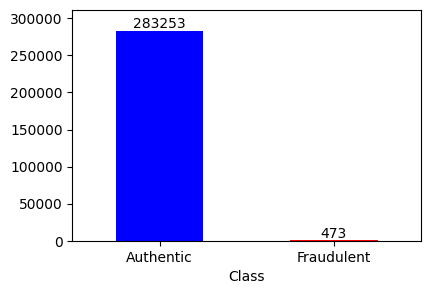

In [13]:
class_counts = df['Class'].replace({0:'Authentic',1:'Fraudulent'}).value_counts()

print(class_counts)
ax = class_counts.plot(kind='bar',color=['b','r'],figsize=(4.5,3))
ax.set_ylim(0, class_counts.max() * 1.1)
plt.xticks(rotation=0)
for container in ax.containers:
    ax.bar_label(container)

> As we can see the classes are heavily imbalanced.

Lets now check for outliers in the data.

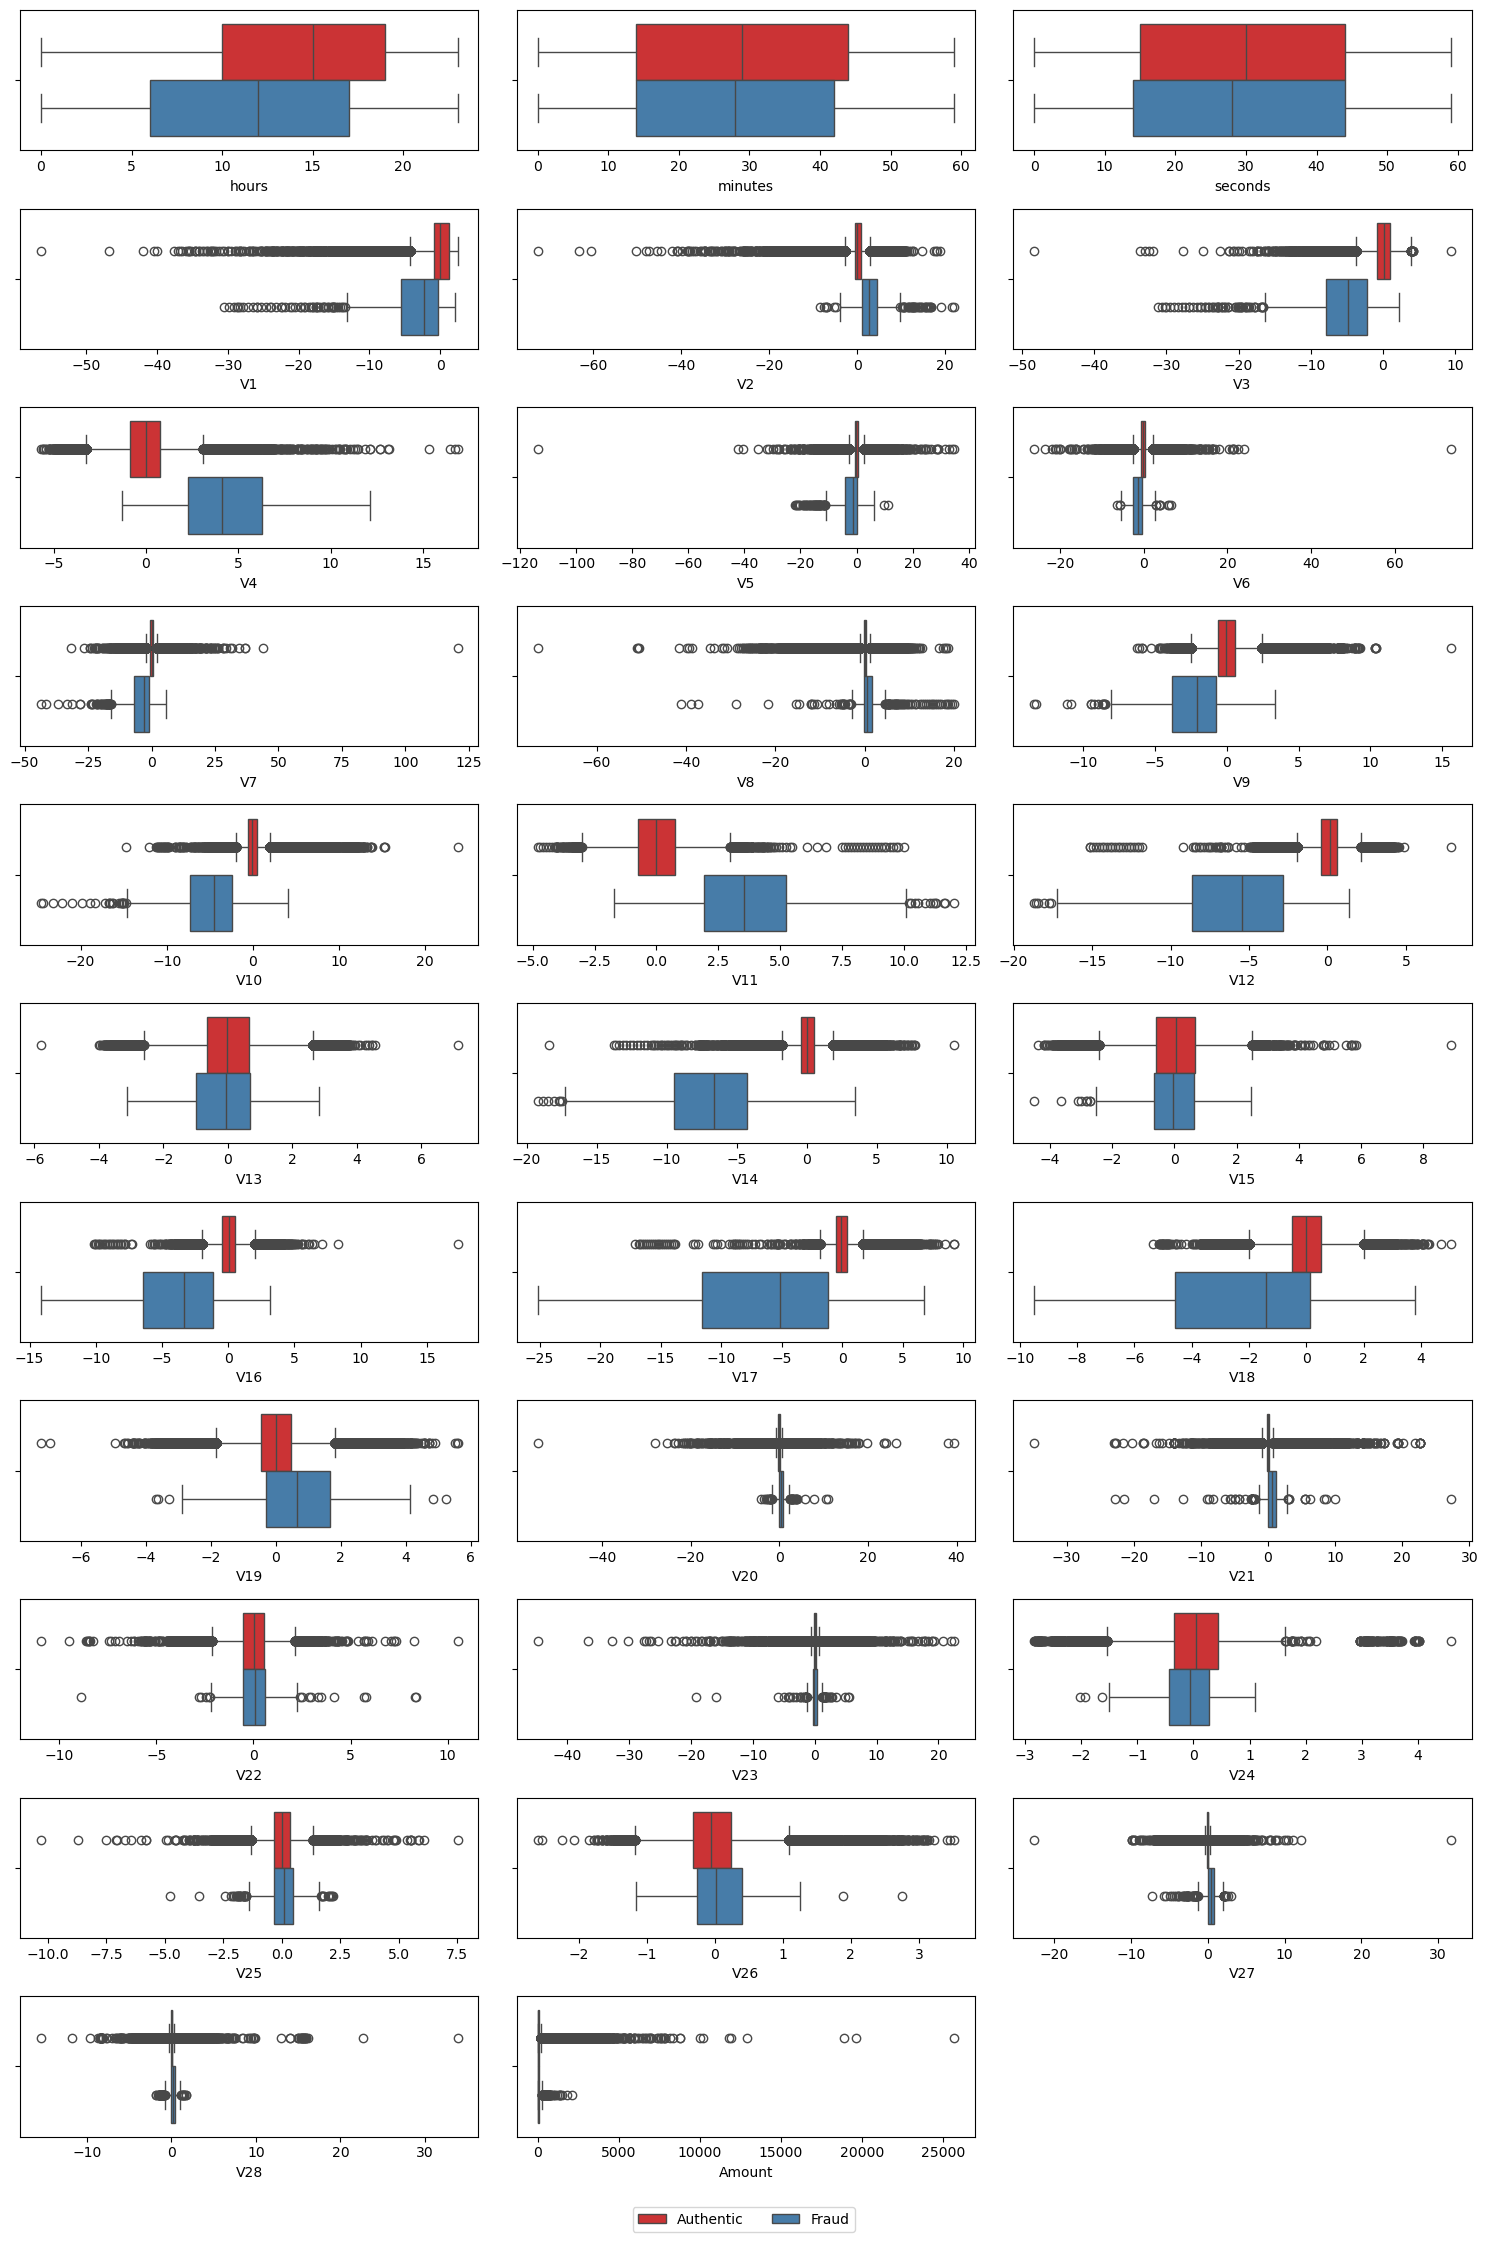

In [14]:
plt.figure(figsize=(3*5,11*2))
for i,col in enumerate(df.columns[:-1]):
    ax = plt.subplot(11,3,i+1)
    sb.boxplot(df, x=col, hue='Class', ax=ax, palette='Set1')
    ax.legend_.remove()
handles, _ = ax.get_legend_handles_labels()
labels = ['Authentic', 'Fraud']
plt.figlegend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout()

We can observe the presence of outliers in most of the features. Since this data comes from real-world transactions, these outlier data points contain authentic transactional information that should not be removed. Therefore, we will retain these data points. Additionally, we will utilize tree-based algorithms, which are inherently more robust to outliers.

To standardize the features, we'll employ the robust scaler. This method scales the data using robust statistics, making it more resistant to the influence of outliers.

In [14]:
X = df.iloc[:,:-1]
y = df['Class']
X.head(3)

,hours,minutes,seconds,V1,V2,V3,V4,V5,V6,V7,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,0,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((226980, 32), (56746, 32), (226980,), (56746,))

## Model Training

**For training a good model for fraud detection it is recommended not to undersample** because when undersampling the majority class, we are loosing valuable information and patterns from the training data, which could have helped the model better distinguish between the two classes. Let's delve into this further below.

In [16]:
df_undersample = pd.concat([df[df['Class'] == 1], df[df['Class'] == 0].sample(473)])
df_undersample['Class'].value_counts()

Class
1    473
0    473
Name: count, dtype: int64

In [20]:
X_undersample = df_undersample.iloc[:,:-1]
y_undersample = df_undersample['Class']
X_undersample_train, X_undersample_test, y_undersample_train, y_undersample_test = \
                train_test_split(X_undersample,y_undersample,test_size=0.20,stratify=y_undersample,shuffle=True,random_state=7)
X_undersample_train.shape, X_undersample_test.shape, y_undersample_train.shape, y_undersample_test.shape

((756, 32), (190, 32), (756,), (190,))

In [21]:
pipe = make_pipeline(
    RobustScaler(),
    XGBClassifier()
)
pipe.fit(X_undersample_train,y_undersample_train)

y_undersample_pred = pipe.predict(X_undersample_test)
report = classification_report(y_undersample_test,y_undersample_pred,target_names=['Authentic', 'Fraud'])

y_pred = pipe.predict(X_test)
report2 = classification_report(y_test,y_pred,target_names=['Authentic', 'Fraud'])

print('--'*35)
print('Eval Metrics for Undersampled Test Set')
print('--'*35)
print(report)
print('--'*35)
print('Eval Metrics for Real Test Set')
print('--'*35)
print(report2)

----------------------------------------------------------------------
Eval Metrics for Undersampled Test Set
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Authentic       0.94      0.97      0.95        95
       Fraud       0.97      0.94      0.95        95

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190

----------------------------------------------------------------------
Eval Metrics for Real Test Set
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Authentic       1.00      0.96      0.98     56651
       Fraud       0.04      0.98      0.07        95

    accuracy                           0.96     56746
   macro avg       0.52      0.97      0.52     56746
weighted avg       1.00      0.96      0.98    

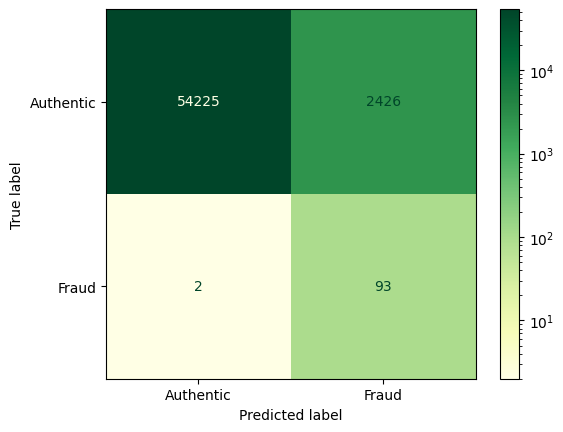

In [30]:
labels = ['Authentic','Fraud']
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=labels,cmap='YlGn')
disp.im_.set_norm(LogNorm(vmax=disp.confusion_matrix.max(),vmin=disp.confusion_matrix.min()))
plt.show()

As seen above, model performs well solely on the undersampled test set, but when evaluated on the real test set, it generates numerous false positives resulting in very low precision for the fraud class. This problem arises due to the undersampling of the authentic class. To mitigate this issue, it's better to train the model on the original data or oversampled data. 

Please note that the aforementioned model still remains useful if we are prioritizing only high recall and precision is not a concern.

In [31]:
models=[
    XGBClassifier(),
    XGBRFClassifier(),
    RandomForestClassifier(),
    HistGradientBoostingClassifier()
]

In [32]:
for model in models:
    pipe = make_pipeline(
        RobustScaler(),
        model
    )
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test,y_pred,target_names=['Authentic', 'Fraud'])
    print('=='*35)
    print(model.__class__.__name__)
    print('--'*35)
    print(report)   

XGBClassifier
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Authentic       1.00      1.00      1.00     56651
       Fraud       0.96      0.82      0.89        95

    accuracy                           1.00     56746
   macro avg       0.98      0.91      0.94     56746
weighted avg       1.00      1.00      1.00     56746

XGBRFClassifier
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Authentic       1.00      1.00      1.00     56651
       Fraud       0.86      0.83      0.84        95

    accuracy                           1.00     56746
   macro avg       0.93      0.92      0.92     56746
weighted avg       1.00      1.00      1.00     56746

RandomForestClassifier
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Authentic       1.00  

These results are alright, but we'll aim to improve the model's performance further by training and tuning it under two scenarios:

- Model trained on original data (non-resampled data).
- Model trained on oversampled data, where class 1 (Fraudulent) has been oversampled to achieve a balance with class 0 (Authentic).

For oversampling, we'll use the Adaptive Synthetic (ADASYN) algorithm. ADASYN creates new samples by focusing on samples that are misclassified using a k-Nearest Neighbors classifier, thus emphasizing regions of the feature space that are difficult to learn.

Additionally, we'll also use another oversampling method called BorderlineSMOTE which is a variant of SMOTE. BorderlineSMOTE specifically targets minority class data points situated near the decision boundary. These data points are more in risk of being misclassified. By generating synthetic instances around these examples, BorderlineSMOTE aims to improve the classifier's decision regions and overall generalization performance.

In [33]:
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train,y_train)
X_train_adasyn.shape, y_train_adasyn.shape

((453104, 32), (453104,))

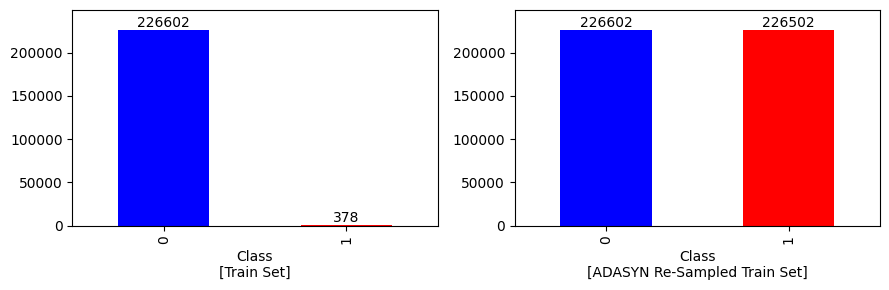

In [34]:
plt.figure(figsize=(9,3))
for i,samples in enumerate([y_train, y_train_adasyn]):
    plt.subplot(1,2,i+1)
    ax = samples.value_counts().plot(kind='bar', color=['b','r'])
    ax.set_ylim(0, samples.value_counts().max() * 1.1)
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')
    plt.xlabel(['Class\n[Train Set]', 'Class\n[ADASYN Re-Sampled Train Set]'][i])
plt.tight_layout()

In [35]:
X_train_border, y_train_border = BorderlineSMOTE().fit_resample(X_train,y_train)
X_train_border.shape, y_train_border.shape

((453204, 32), (453204,))

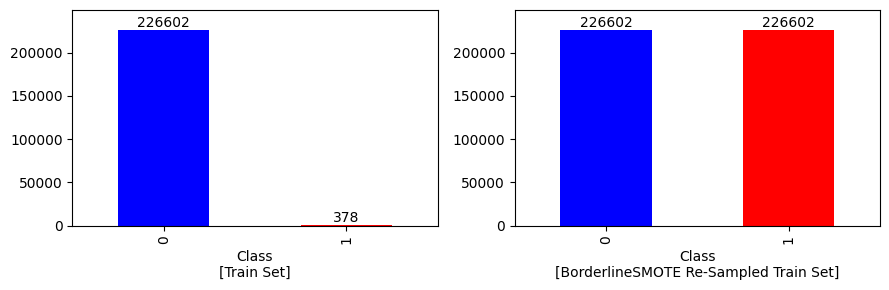

In [36]:
plt.figure(figsize=(9,3))
for i,samples in enumerate([y_train, y_train_border]):
    plt.subplot(1,2,i+1)
    ax = samples.value_counts().plot(kind='bar', color=['b','r'])
    ax.set_ylim(0, samples.value_counts().max() * 1.1)
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')
    plt.xlabel(['Class\n[Train Set]', 'Class\n[BorderlineSMOTE Re-Sampled Train Set]'][i])
plt.tight_layout()

In [37]:
def get_aucpr(model,X_test,y_test):
    '''
    To calculate area under precision recall curve
    '''
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    # Were doing the step below to make sure that precision is in descending order (it is required by auc())
    sorted_idx = np.argsort(precision)[::-1]
    precision = precision[sorted_idx]
    # Precision and recall values should be aligned correctly
    recall = recall[sorted_idx]
    aucpr = auc(precision, recall)
    
    return aucpr

### Model Tuning

`The goal is to train a model that prioritizes high recall while maintaining an acceptable precision level, as false negatives in this scenario are much more critical and can lead to significant financial losses.` 

To achieve this, we will use Optuna, setting its objective to maximizing the area under the precision-recall curve (AUCPR). Once we have the optimized model, we can adjust its thresholds to achieve the desired balance between precision and recall. While other options like optimizing for F2 or F3 scores could also be used, we will proceed with this approach now.

#### Training on Non Resampled data

In [38]:
fixed_params = {
    'n_estimators': 200,
    'device': 'cuda',
    'tree_method': 'hist',
    'n_jobs': -1
}

In [38]:
# Defining the model tuning objective function (maximizing aucpr)
def objective(trial):

    params = {
        'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 1, 12),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.05, 1),
        'subsample':         trial.suggest_float('subsample', 0.05, 1),
        'min_child_weight':  trial.suggest_float('min_child_weight', 1, 20),
        'scale_pos_weight':  trial.suggest_float('scale_pos_weight', 1, 50),
    }
    
    xgbc = XGBClassifier(**params, **fixed_params)
    
    aucpr_scores = []
    recall_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_train_cv, y_train_cv = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_test_cv, y_test_cv = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        # We have to make sure that scaling parameters are learned only from the train fold
        # To prevent data leakage
        scaler_robust = RobustScaler()
        X_train_cv = scaler_robust.fit_transform(X_train_cv)
        X_test_cv = scaler_robust.transform(X_test_cv)
        # To speed up training by using GPU
        X_train_cv_gpu = cupy.array(X_train_cv)
        X_test_cv_gpu = cupy.array(X_test_cv)

        xgbc.fit(X_train_cv_gpu, y_train_cv)
        
        fold_aucpr = get_aucpr(xgbc,X_test_cv_gpu,y_test_cv)
        fold_recall = recall_score(y_test_cv, xgbc.predict(X_test_cv_gpu))
        recall_scores.append(fold_recall)
        aucpr_scores.append(fold_aucpr)
        
        # This is to add a custom attribute (recall) in the study info for each trial
        trial.set_user_attr('recall', np.mean(recall_scores))

    return np.mean(aucpr_scores)

TPESampler = optuna.samplers.TPESampler(multivariate=True, group=True)
optimize_aucpr = optuna.create_study(direction='maximize',
                                     sampler=TPESampler,
                                     study_name='Optimizing AUCPR')

[I 2024-05-18 08:30:48,313] A new study created in memory with name: Optimizing AUCPR


In [39]:
# Will run for 300 trials
optimize_aucpr.optimize(objective, n_trials=300)
dump(optimize_aucpr,'Optimizing AUCPR Study.pkl')

[I 2024-05-18 08:31:07,418] Trial 0 finished with value: 0.8234701819654309 and parameters: {'learning_rate': 0.018502239095126806, 'max_depth': 12, 'colsample_bytree': 0.5264781557619446, 'subsample': 0.8492170008555465, 'min_child_weight': 11.513415103406139, 'scale_pos_weight': 6.929495888831088}. Best is trial 0 with value: 0.8234701819654309.
[I 2024-05-18 08:31:13,411] Trial 1 finished with value: 0.7842375343926944 and parameters: {'learning_rate': 0.006570585518293666, 'max_depth': 10, 'colsample_bytree': 0.8633862942136941, 'subsample': 0.6033264920709361, 'min_child_weight': 19.25737478652087, 'scale_pos_weight': 47.50144634658771}. Best is trial 0 with value: 0.8234701819654309.
[I 2024-05-18 08:31:18,430] Trial 2 finished with value: 0.7610179690427008 and parameters: {'learning_rate': 0.0024978471668192126, 'max_depth': 8, 'colsample_bytree': 0.9333577322558657, 'subsample': 0.2693268924536365, 'min_child_weight': 17.451366421623973, 'scale_pos_weight': 14.320529592345414}

['Optimizing AUCPR Study.pkl']

In [40]:
optuna.visualization.plot_optimization_history(optimize_aucpr)

*The figure above is an Optimization History Plot generated by Optuna. It displays the progression of the objective function's values over the course of the hyperparameter optimization process. This plot helps visualize how the optimization algorithm explores the hyperparameter space and how the objective function improves over time. Hovering over each dot (representing a trial) provides information on the trial number and the objective value obtained at that particular trial.*

In [41]:
# Getting all of trials info in a dataframe
optimize_aucpr_df = optimize_aucpr.trials_dataframe().rename({'user_attrs_recall':'recall','value':'aucpr'},axis=1)

new_order = ['number','aucpr','recall'] + list(optimize_aucpr_df.drop(['number','aucpr','recall'],axis=1).columns)
optimize_aucpr_df = optimize_aucpr_df[new_order]

optimize_aucpr_df.sample(5)

,number,aucpr,recall,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_scale_pos_weight,params_subsample,state
118,118,0.831154,0.775088,2024-05-18 08:41:57.580343,2024-05-18 08:42:02.899998,0 days 00:00:05.319655,0.993339,0.032495,12,2.146412,2.497118,0.427927,COMPLETE
246,246,0.765101,0.798737,2024-05-18 08:53:43.145489,2024-05-18 08:53:46.803507,0 days 00:00:03.658018,0.941571,0.009702,2,19.365244,22.164149,0.718195,COMPLETE
231,231,0.835459,0.793544,2024-05-18 08:52:17.705114,2024-05-18 08:52:23.144631,0 days 00:00:05.439517,0.792190,0.079865,7,3.136093,15.014347,0.978515,COMPLETE
170,170,0.835231,0.814667,2024-05-18 08:46:47.192571,2024-05-18 08:46:52.935439,0 days 00:00:05.742868,0.744940,0.065121,10,9.164615,45.455501,0.903189,COMPLETE
141,141,0.835135,0.806772,2024-05-18 08:44:04.560018,2024-05-18 08:44:10.350594,0 days 00:00:05.790576,0.568190,0.074592,11,6.385819,27.759981,0.932945,COMPLETE


In [42]:
optimize_aucpr_df.nlargest(5,'aucpr')

,number,aucpr,recall,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_scale_pos_weight,params_subsample,state
90,90,0.841390,0.812035,2024-05-18 08:39:16.632915,2024-05-18 08:39:22.177464,0 days 00:00:05.544549,0.680981,0.087300,12,4.170022,26.180102,0.397730,COMPLETE
108,108,0.841322,0.796246,2024-05-18 08:40:57.707093,2024-05-18 08:41:03.608838,0 days 00:00:05.901745,0.729265,0.086919,11,1.165523,9.434632,0.758171,COMPLETE
143,143,0.841201,0.793614,2024-05-18 08:44:16.099875,2024-05-18 08:44:21.886301,0 days 00:00:05.786426,0.574607,0.098619,9,1.068790,12.123657,0.857444,COMPLETE
198,198,0.841109,0.796211,2024-05-18 08:49:21.573169,2024-05-18 08:49:27.555330,0 days 00:00:05.982161,0.658854,0.076486,10,1.980608,31.344270,0.830956,COMPLETE
192,192,0.840924,0.798807,2024-05-18 08:48:48.789275,2024-05-18 08:48:54.578716,0 days 00:00:05.789441,0.552424,0.077856,10,3.525967,15.810692,0.895078,COMPLETE


In [43]:
xg = XGBClassifier(**fixed_params, **optimize_aucpr.best_trial.params)
pipe = make_pipeline(RobustScaler(), 
                     xg)
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

recall = recall_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
aucpr = get_aucpr(pipe,X_test,y_test)
print('--'*32)
print(f'Eval metrics of model from the best trial')
print('--'*32)
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'AUCPR: {aucpr:.4f}\n')

----------------------------------------------------------------
Eval metrics of model from the best trial
----------------------------------------------------------------
Recall: 0.8316
Precision: 0.9186
AUCPR: 0.8801



> As mentoned, these are the Precision, Recall and AUCPR values of the best model obtained, for the test set

We'll also try running a multi-objective hyperparameter tuning using Optuna, `optimizing for both precision and recall simultaneously.`

The objective for this is to find a solution that strikes the optimal balance between precision and recall, a process often described as finding a Pareto optimal solution. A solution is considered Pareto optimal if there exists no other solution that is superior in all other objectives. This means that improving one objective value cannot be done without sacrificing another. **After adequate tuning, we aim to find solutions on the Pareto front, offering optimal trade-offs between precision and recall.**

In [17]:
# Defining the model tuning objective function (maximizing precision, recall)
def objective(trial):

    params = {
        'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 1, 12),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.05, 1),
        'subsample':         trial.suggest_float('subsample', 0.05, 1),
        'min_child_weight':  trial.suggest_float('min_child_weight', 1, 20),
        'scale_pos_weight':  trial.suggest_float('scale_pos_weight', 1, 50),
    }
    
    xgbc = XGBClassifier(**params, **fixed_params)
    
    recall_scores = []
    precision_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_train_cv, y_train_cv = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_test_cv, y_test_cv = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        # We have to make sure that scaling parameters are learned only from the train fold
        # To prevent data leakage
        scaler_robust = RobustScaler()
        X_train_cv = scaler_robust.fit_transform(X_train_cv)
        X_test_cv = scaler_robust.transform(X_test_cv)
        # To speed up training by using GPU
        X_train_cv_gpu = cupy.array(X_train_cv)
        X_test_cv_gpu = cupy.array(X_test_cv)

        xgbc.fit(X_train_cv_gpu, y_train_cv)
        
        fold_recall = recall_score(y_test_cv, xgbc.predict(X_test_cv_gpu))
        fold_precision = precision_score(y_test_cv, xgbc.predict(X_test_cv_gpu))
        recall_scores.append(fold_recall)
        precision_scores.append(fold_precision)

    return np.mean(precision_scores), np.mean(recall_scores)

TPESampler = optuna.samplers.TPESampler(multivariate=True,group=True)
Optimize_precision_recall = optuna.create_study(directions=['maximize','maximize'],
                                                sampler=TPESampler,
                                                study_name='Optimizing Precision & Recall')

[I 2024-05-18 13:04:05,680] A new study created in memory with name: Optimizing Precision & Recall


In [18]:
Optimize_precision_recall.optimize(objective, n_trials=300)
dump(Optimize_precision_recall,'Optimizing Precision & Recall Study.pkl')

[I 2024-05-18 13:05:04,595] Trial 0 finished with values: [0.7057388645491055, 0.8172982456140352] and parameters: {'learning_rate': 0.032218740321957456, 'max_depth': 7, 'colsample_bytree': 0.763602355230684, 'subsample': 0.15694655359984783, 'min_child_weight': 17.47872326810848, 'scale_pos_weight': 25.923986317466625}. 
[I 2024-05-18 13:05:09,482] Trial 1 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0019257709139787558, 'max_depth': 9, 'colsample_bytree': 0.07655277186687941, 'subsample': 0.8410445788200434, 'min_child_weight': 5.2374579951651645, 'scale_pos_weight': 1.760014606597802}. 
[I 2024-05-18 13:05:16,219] Trial 2 finished with values: [0.8269890377939915, 0.7935087719298246] and parameters: {'learning_rate': 0.01179345026936469, 'max_depth': 11, 'colsample_bytree': 0.36544138159973777, 'subsample': 0.8782682549315812, 'min_child_weight': 17.391575901844007, 'scale_pos_weight': 17.88184506310253}. 
[I 2024-05-18 13:05:20,306] Trial 3 finished with va

['Optimizing Precision & Recall Study2.pkl']

In [45]:
optuna.visualization.plot_pareto_front(Optimize_precision_recall, target_names=["Precision", "Recall"])

*The plot above is a Pareto front plot generated by Optuna, illustrating the best trade-offs achieved during the trials. This plot enable quick identification of the trials situated on the Pareto frontier, highlighted in red. Hovering over each point reveals detailed information for that trial, including the sampled hyperparameters.*

In [46]:
# Getting all of trials info in a dataframe
Optimize_precision_recall_df = Optimize_precision_recall.trials_dataframe() \
                                    .rename({'values_1':'recall','values_0':'precision'},axis=1)
Optimize_precision_recall_df.head(2)

,number,precision,recall,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_scale_pos_weight,params_subsample,state
0,0,0.705739,0.817298,2024-05-18 13:04:58.937009,2024-05-18 13:05:04.594766,0 days 00:00:05.657757,0.763602,0.032219,7,17.478723,25.923986,0.156947,COMPLETE
1,1,0.000000,0.000000,2024-05-18 13:05:04.595957,2024-05-18 13:05:09.482240,0 days 00:00:04.886283,0.076553,0.001926,9,5.237458,1.760015,0.841045,COMPLETE


**Pareto-front Trials (best trade-off)**

In [47]:
pareto_trials = [trial.number for trial in Optimize_precision_recall.best_trials]
Optimize_precision_recall_df['pareto_trials'] = np.where(Optimize_precision_recall_df['number'].isin(pareto_trials),'yes','no')
Optimize_precision_recall_df[Optimize_precision_recall_df['pareto_trials'] == 'yes']

,number,precision,recall,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_scale_pos_weight,params_subsample,state,pareto_trials
22,22,0.829468,0.819965,2024-05-18 13:06:58.852672,2024-05-18 13:07:03.886975,0 days 00:00:05.034303,0.469576,0.045384,5,4.622426,31.225164,0.588861,COMPLETE,yes
33,33,0.802860,0.820000,2024-05-18 13:07:53.787841,2024-05-18 13:07:58.610368,0 days 00:00:04.822527,0.560866,0.090711,5,9.256937,43.247636,0.328946,COMPLETE,yes
37,37,0.656219,0.835860,2024-05-18 13:08:11.834013,2024-05-18 13:08:15.783940,0 days 00:00:03.949927,0.916633,0.075558,2,1.230759,26.997756,0.346706,COMPLETE,yes
45,45,0.917915,0.790912,2024-05-18 13:08:46.998684,2024-05-18 13:08:53.645494,0 days 00:00:06.646810,0.681773,0.046632,12,1.809015,26.910774,0.593456,COMPLETE,yes
73,73,0.798304,0.827930,2024-05-18 13:11:12.273345,2024-05-18 13:11:16.919120,0 days 00:00:04.645775,0.431596,0.062605,4,5.919339,28.670000,0.688982,COMPLETE,yes
83,83,0.682759,0.833193,2024-05-18 13:11:59.604755,2024-05-18 13:12:03.679659,0 days 00:00:04.074904,0.975052,0.061905,2,1.166171,22.971691,0.518023,COMPLETE,yes
113,113,0.917848,0.790947,2024-05-18 13:14:37.417014,2024-05-18 13:14:43.425427,0 days 00:00:06.008413,0.787213,0.042462,11,5.785140,2.903911,0.794823,COMPLETE,yes
127,127,0.933340,0.759158,2024-05-18 13:15:54.379890,2024-05-18 13:16:00.058870,0 days 00:00:05.678980,0.450579,0.023159,11,1.307802,1.411463,0.596954,COMPLETE,yes
131,131,0.925483,0.772421,2024-05-18 13:16:16.518263,2024-05-18 13:16:22.903717,0 days 00:00:06.385454,0.385365,0.044852,12,2.180802,3.624643,0.650383,COMPLETE,yes
147,147,0.935451,0.745965,2024-05-18 13:17:48.595097,2024-05-18 13:17:54.103992,0 days 00:00:05.508895,0.548269,0.012847,11,1.092531,1.505323,0.590307,COMPLETE,yes


In [48]:
for i in Optimize_precision_recall_df.query("`pareto_trials` == 'yes'")['number']:
    xg = XGBClassifier(**fixed_params, **Optimize_precision_recall.trials[i].params)
    pipe = make_pipeline(RobustScaler(), 
                         xg)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)

    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    aucpr = get_aucpr(pipe,X_test,y_test)
    print('--'*32)
    print(f'Eval Metrics for Model from trial num: {i}')
    print('--'*32)
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'AUCPR: {aucpr:.4f}\n')

----------------------------------------------------------------
Eval Metrics for Model from trial num: 22
----------------------------------------------------------------
Recall: 0.8526
Precision: 0.8617
AUCPR: 0.8745

----------------------------------------------------------------
Eval Metrics for Model from trial num: 33
----------------------------------------------------------------
Recall: 0.8421
Precision: 0.8791
AUCPR: 0.8755

----------------------------------------------------------------
Eval Metrics for Model from trial num: 37
----------------------------------------------------------------
Recall: 0.8737
Precision: 0.6288
AUCPR: 0.8537

----------------------------------------------------------------
Eval Metrics for Model from trial num: 45
----------------------------------------------------------------
Recall: 0.8316
Precision: 0.9186
AUCPR: 0.8774

----------------------------------------------------------------
Eval Metrics for Model from trial num: 73
-------------

> Based on the results, the model from trial 274 showcases the most favorable trade-off values and achieves the highest AUCPR, surpassing the AUCPR of the best trial from the previous tuning.

#### Training on Resampled Data

`We'll conduct the same two hyperparameter tuning processes on resampled data to determine if we can further improve the evaluation metrics.`

In [36]:
# Defining the model tuning objective function (maximizing aucpr on resampled data)
def objective(trial):

    params = { 
        # We are using the same params as before except scale_pos_weight 
        # since we are balancing the classes using resampling
        'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 1, 12),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.05, 1),
        'subsample':         trial.suggest_float('subsample', 0.05, 1),
        'min_child_weight':  trial.suggest_float('min_child_weight', 1, 20),
    }
    
    xgbc = XGBClassifier(**params, **fixed_params)

    aucpr_scores = []
    recall_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_train_cv, y_train_cv = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_test_cv, y_test_cv = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        # For choosing between the two resampling methods during tuning process
        sampling_method = trial.suggest_categorical('sampling_method', ['BorderlineSMOTE', 'ADASYN'])
        
        # Here we are making sure that oversampling happens only on the train split of X_train during cross-validation
        # This is to prevent data leakage that will happen if over sampling is applied to the whole of X_train
        if sampling_method == 'BorderlineSMOTE':
            X_train_cv, y_train_cv = BorderlineSMOTE(random_state=0).fit_resample(X_train_cv, y_train_cv)

        if sampling_method == 'ADASYN':
            X_train_cv, y_train_cv = ADASYN(random_state=0).fit_resample(X_train_cv, y_train_cv)
        
        # Scaling the train and test before training and storing as gpu array for gpu training
        scaler_robust = RobustScaler()
        X_train_cv = scaler_robust.fit_transform(X_train_cv)
        X_test_cv = scaler_robust.transform(X_test_cv)
        X_train_cv_gpu = cupy.array(X_train_cv)
        X_test_cv_gpu = cupy.array(X_test_cv)

        xgbc.fit(X_train_cv_gpu, y_train_cv)
        
        fold_aucpr = get_aucpr(xgbc,X_test_cv_gpu,y_test_cv)
        fold_recall = recall_score(y_test_cv, xgbc.predict(X_test_cv_gpu))
        recall_scores.append(fold_recall)
        aucpr_scores.append(fold_aucpr)
        
        trial.set_user_attr('recall', np.mean(recall_scores))

    return np.mean(aucpr_scores)

TPESampler = optuna.samplers.TPESampler(multivariate=True, group=True)
optimize_resampled_aucpr = optuna.create_study(direction='maximize',
                                               sampler=TPESampler,
                                               study_name='Optimizing AUCPR (Resampled Data)')

[I 2024-05-18 13:46:34,894] A new study created in memory with name: Optimizing AUCPR (Resampled Data)


In [37]:
optimize_resampled_aucpr.optimize(objective, n_trials=300)
dump(optimize_resampled_aucpr,'Optimizing AUCPR Study (Resampled Data).pkl')

[I 2024-05-18 13:46:49,378] Trial 0 finished with value: 0.8051982258051653 and parameters: {'learning_rate': 0.056787079790889365, 'max_depth': 8, 'colsample_bytree': 0.628341477526758, 'subsample': 0.14678048212179384, 'min_child_weight': 5.415164469362309, 'sampling_method': 'BorderlineSMOTE'}. Best is trial 0 with value: 0.8051982258051653.
[I 2024-05-18 13:47:01,390] Trial 1 finished with value: 0.82616063434729 and parameters: {'learning_rate': 0.06663328084345978, 'max_depth': 9, 'colsample_bytree': 0.8473409320307239, 'subsample': 0.2941279221313862, 'min_child_weight': 4.311673731844359, 'sampling_method': 'ADASYN'}. Best is trial 1 with value: 0.82616063434729.
[I 2024-05-18 13:47:10,107] Trial 2 finished with value: 0.7340545977519698 and parameters: {'learning_rate': 0.04391108822546718, 'max_depth': 2, 'colsample_bytree': 0.3255521638616482, 'subsample': 0.6940179274078416, 'min_child_weight': 6.3031311541902655, 'sampling_method': 'ADASYN'}. Best is trial 1 with value: 0.

['Optimizing AUCPR Study (Resampled Data).pkl']

In [50]:
optuna.visualization.plot_optimization_history(optimize_resampled_aucpr)

In [51]:
optimize_resampled_aucpr_df = optimize_resampled_aucpr.trials_dataframe() \
                                .rename({'user_attrs_recall':'recall','value':'aucpr'},axis=1)

new_order = ['number','aucpr','recall'] + list(optimize_resampled_aucpr_df.drop(['number','aucpr','recall'],axis=1).columns)
optimize_resampled_aucpr_df = optimize_resampled_aucpr_df[new_order]

optimize_resampled_aucpr_df.head(2)

,number,aucpr,recall,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_sampling_method,params_subsample,state
0,0,0.805198,0.835860,2024-05-18 13:46:38.511684,2024-05-18 13:46:49.377538,0 days 00:00:10.865854,0.628341,0.056787,8,5.415164,BorderlineSMOTE,0.146780,COMPLETE
1,1,0.826161,0.835895,2024-05-18 13:46:49.379147,2024-05-18 13:47:01.389755,0 days 00:00:12.010608,0.847341,0.066633,9,4.311674,ADASYN,0.294128,COMPLETE


In [52]:
optimize_resampled_aucpr_df.nlargest(5,'aucpr')

,number,aucpr,recall,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_sampling_method,params_subsample,state
210,210,0.849853,0.830561,2024-05-18 14:30:27.939622,2024-05-18 14:30:41.139791,0 days 00:00:13.200169,0.668454,0.097833,12,1.955731,ADASYN,0.570583,COMPLETE
293,293,0.846116,0.827930,2024-05-18 14:48:05.485262,2024-05-18 14:48:18.551103,0 days 00:00:13.065841,0.707232,0.093862,12,3.854902,ADASYN,0.771422,COMPLETE
223,223,0.845756,0.830561,2024-05-18 14:33:18.295885,2024-05-18 14:33:31.252328,0 days 00:00:12.956443,0.676550,0.087852,12,3.971729,ADASYN,0.608275,COMPLETE
208,208,0.845508,0.830561,2024-05-18 14:30:01.669998,2024-05-18 14:30:14.931272,0 days 00:00:13.261274,0.640384,0.098164,12,3.104035,ADASYN,0.759512,COMPLETE
160,160,0.845037,0.830561,2024-05-18 14:19:10.321939,2024-05-18 14:19:24.635106,0 days 00:00:14.313167,0.494663,0.089070,12,2.853853,ADASYN,0.947014,COMPLETE


> Please note that 'params_sampling_method' is not a parameter of XGBoost. Instead, it is a custom categorical variable utilized using Optuna's suggest method. It allowed us to efficiently identify the best resampling method (ADASYN or BorderlineSMOTE) for maximizing AUCPR during the model tuning process itself, rather than running separate optimization processes for each resampling method.

In [53]:
parameters = optimize_resampled_aucpr.best_trial.params
method = parameters.pop('sampling_method')

xg_res = XGBClassifier(**fixed_params,**parameters)
pipe_res = make_pipeline_imb(ADASYN(random_state=0),
                             RobustScaler(),
                             xg_res)

pipe_res.fit(X_train,y_train)
y_pred = pipe_res.predict(X_test)

recall = recall_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
aucpr = get_aucpr(pipe_res,X_test,y_test)
print('--'*32)
print('Eval metrics of model from the best trial')
print('--'*32)
print(f'Sampling Method: {method}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'AUCPR: {aucpr:.4f}\n')

----------------------------------------------------------------
Eval metrics of model from the best trial
----------------------------------------------------------------
Sampling Method: ADASYN
Recall: 0.8632
Precision: 0.8632
AUCPR: 0.8856



**We got the best results yet from ADASYN resampled dataset with an AUCPR of 88.56**

`Multi-Objective optimization of both Precision and Recall on resampled data`

In [48]:
# Defining the model tuning objective function (maximizing precision and recall (resampled data))
def objective(trial):

    params = { 
        'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 1, 12),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.05, 1),
        'subsample':         trial.suggest_float('subsample', 0.05, 1),
        'min_child_weight':  trial.suggest_float('min_child_weight', 1, 20),
    }
    
    xgbc = XGBClassifier(**params, **fixed_params)

    precision_scores = []
    recall_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_train_cv, y_train_cv = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_test_cv, y_test_cv = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        sampling_method = trial.suggest_categorical('sampling_method', ['BorderlineSMOTE', 'ADASYN'])
        
        if sampling_method == 'BorderlineSMOTE':
            X_train_cv, y_train_cv = BorderlineSMOTE(random_state=0).fit_resample(X_train_cv, y_train_cv)

        if sampling_method == 'ADASYN':
            X_train_cv, y_train_cv = ADASYN(random_state=0).fit_resample(X_train_cv, y_train_cv)
        
        scaler_robust = RobustScaler()
        X_train_cv = scaler_robust.fit_transform(X_train_cv)
        X_test_cv = scaler_robust.transform(X_test_cv)
        X_train_cv_gpu = cupy.array(X_train_cv)
        X_test_cv_gpu = cupy.array(X_test_cv)

        xgbc.fit(X_train_cv_gpu, y_train_cv)
        
        fold_precision = precision_score(y_test_cv, xgbc.predict(X_test_cv_gpu))
        fold_recall = recall_score(y_test_cv, xgbc.predict(X_test_cv_gpu))
        recall_scores.append(fold_recall)
        precision_scores.append(fold_precision)

    return np.mean(precision_scores), np.mean(recall_scores)

TPESampler = optuna.samplers.TPESampler(multivariate=True, group=True)
optimize_res_precision_recall = optuna.create_study(directions=['maximize','maximize'],
                                                    sampler=TPESampler,
                                                    study_name='Optimizing Precision & Recall (Resampled Data)')

[I 2024-05-20 12:33:07,101] A new study created in memory with name: Optimizing Precision & Recall (Resampled Data)


In [49]:
optimize_res_precision_recall.optimize(objective, n_trials=300)
dump(optimize_res_precision_recall,'Optimizing Precision & Recall Study (Resampled Data).pkl')

[I 2024-05-20 12:33:36,469] Trial 0 finished with values: [0.198639725008582, 0.8542105263157895] and parameters: {'learning_rate': 0.004567094219718554, 'max_depth': 9, 'colsample_bytree': 0.7765739678068798, 'subsample': 0.6636767618130208, 'min_child_weight': 11.058332217609047, 'sampling_method': 'ADASYN'}. 
[I 2024-05-20 12:33:44,711] Trial 1 finished with values: [0.030535403853566827, 0.8887368421052632] and parameters: {'learning_rate': 0.003143115692988436, 'max_depth': 1, 'colsample_bytree': 0.47730743347139176, 'subsample': 0.9726862428667766, 'min_child_weight': 16.286347993761566, 'sampling_method': 'ADASYN'}. 
[I 2024-05-20 12:33:56,442] Trial 2 finished with values: [0.12208168683944134, 0.8674385964912281] and parameters: {'learning_rate': 0.004207116841292167, 'max_depth': 7, 'colsample_bytree': 0.7224994663319543, 'subsample': 0.657979610639746, 'min_child_weight': 12.465619688475785, 'sampling_method': 'ADASYN'}. 
[I 2024-05-20 12:34:05,526] Trial 3 finished with val

['Optimizing Precision & Recall Study (Resampled Data).pkl']

In [55]:
optuna.visualization.plot_pareto_front(optimize_res_precision_recall, target_names=['precision','recall'])

In [56]:
optimize_res_precision_recall_df = optimize_res_precision_recall.trials_dataframe() \
                                    .rename({'values_1':'recall','values_0':'precision'},axis=1)
optimize_res_precision_recall_df.head(2)

,number,precision,recall,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_sampling_method,params_subsample,state
0,0,0.198640,0.854211,2024-05-20 12:33:21.548578,2024-05-20 12:33:36.469593,0 days 00:00:14.921015,0.776574,0.004567,9,11.058332,ADASYN,0.663677,COMPLETE
1,1,0.030535,0.888737,2024-05-20 12:33:36.470864,2024-05-20 12:33:44.710974,0 days 00:00:08.240110,0.477307,0.003143,1,16.286348,ADASYN,0.972686,COMPLETE


In [57]:
pareto_trials = [trials.number for trials in optimize_res_precision_recall.best_trials]
optimize_res_precision_recall_df['pareto_trials'] = np.where(optimize_res_precision_recall_df['number'].isin(pareto_trials),'yes','no')
optimize_res_precision_recall_df.query("`pareto_trials` == 'yes'")

,number,precision,recall,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_sampling_method,params_subsample,state,pareto_trials
48,48,0.142467,0.891333,2024-05-20 12:42:21.317410,2024-05-20 12:42:31.238702,0 days 00:00:09.921292,0.621363,0.029177,5,19.342551,ADASYN,0.137643,COMPLETE,yes
55,55,0.810898,0.822667,2024-05-20 12:43:50.423124,2024-05-20 12:44:01.253876,0 days 00:00:10.830752,0.589407,0.087337,11,16.584514,BorderlineSMOTE,0.924154,COMPLETE,yes
68,68,0.867126,0.798912,2024-05-20 12:46:15.285570,2024-05-20 12:46:26.874018,0 days 00:00:11.588448,0.871754,0.080421,9,1.406707,BorderlineSMOTE,0.921966,COMPLETE,yes
78,78,0.573154,0.854386,2024-05-20 12:48:17.750651,2024-05-20 12:48:29.293164,0 days 00:00:11.542513,0.666634,0.083068,12,8.450699,ADASYN,0.118496,COMPLETE,yes
97,97,0.460526,0.872842,2024-05-20 12:51:55.342963,2024-05-20 12:52:06.522895,0 days 00:00:11.179932,0.645879,0.075182,12,10.379974,ADASYN,0.066908,COMPLETE,yes
116,116,0.549566,0.857018,2024-05-20 12:55:51.428078,2024-05-20 12:56:03.021907,0 days 00:00:11.593829,0.667528,0.097210,12,6.857045,ADASYN,0.078424,COMPLETE,yes
119,119,0.848834,0.820000,2024-05-20 12:56:20.842303,2024-05-20 12:56:33.463365,0 days 00:00:12.621062,0.135881,0.066020,9,2.836589,BorderlineSMOTE,0.628539,COMPLETE,yes
120,120,0.163590,0.888702,2024-05-20 12:56:33.464666,2024-05-20 12:56:43.937157,0 days 00:00:10.472491,0.595363,0.028675,6,19.485423,ADASYN,0.070240,COMPLETE,yes
149,149,0.059776,0.907228,2024-05-20 13:01:53.498517,2024-05-20 13:02:01.748172,0 days 00:00:08.249655,0.882251,0.091195,1,18.047052,ADASYN,0.446043,COMPLETE,yes
158,158,0.583755,0.846456,2024-05-20 13:03:28.055316,2024-05-20 13:03:40.392960,0 days 00:00:12.337644,0.819569,0.063540,12,5.345201,ADASYN,0.120235,COMPLETE,yes


> From the above pareto_trials, we'll get the eval metrics on test set for models having both precision and recall greater than 0.80

In [58]:
for i in optimize_res_precision_recall_df.query("`pareto_trials` == 'yes'")['number']:
    parameters = optimize_res_precision_recall.trials[i].params
    method = parameters.pop('sampling_method')
    
    xg_res = XGBClassifier(**fixed_params,**parameters)
    
    if method == 'ADASYN':
        pipe_res = make_pipeline_imb(ADASYN(random_state=0),
                                     RobustScaler(),
                                     xg_res)
    else:
        pipe_res = make_pipeline_imb(BorderlineSMOTE(random_state=0),
                                     RobustScaler(),
                                     xg_res)

    pipe_res.fit(X_train,y_train)
    y_pred = pipe_res.predict(X_test)

    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    aucpr = get_aucpr(pipe_res,X_test,y_test)
    print('--'*32)
    print(f'Model from trial num: {i}')
    print('--'*32)
    print(f'Sampling Method: {method}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'AUCPR: {aucpr:.4f}\n')

----------------------------------------------------------------
Model from trial num: 48
----------------------------------------------------------------
Sampling Method: ADASYN
Recall: 0.9053
Precision: 0.1148
AUCPR: 0.8369

----------------------------------------------------------------
Model from trial num: 55
----------------------------------------------------------------
Sampling Method: BorderlineSMOTE
Recall: 0.8526
Precision: 0.8438
AUCPR: 0.8706

----------------------------------------------------------------
Model from trial num: 68
----------------------------------------------------------------
Sampling Method: BorderlineSMOTE
Recall: 0.8421
Precision: 0.9091
AUCPR: 0.8715

----------------------------------------------------------------
Model from trial num: 78
----------------------------------------------------------------
Sampling Method: ADASYN
Recall: 0.8947
Precision: 0.5822
AUCPR: 0.8530

----------------------------------------------------------------
Model fro

**After comparing all models from the Pareto trials (multi-objective) and the best trials (single objective), the model achieving the highest AUCPR scores was obtained while optimizing for AUCPR on the resampled dataset. We'll utilize this model as the final model and if needed, we can adjust the thresholds as necessary to achieve the desired precision and recall values.**

In [59]:
# Training the best model
parameters = optimize_resampled_aucpr.best_trial.params
parameters.pop('sampling_method')

xg = XGBClassifier(**fixed_params,**parameters)
best_model = make_pipeline_imb(ADASYN(random_state=0),
                               RobustScaler(),
                               xg)

best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

**Plotting the Precision-Recall Curve and the ROC Curve of the best model**

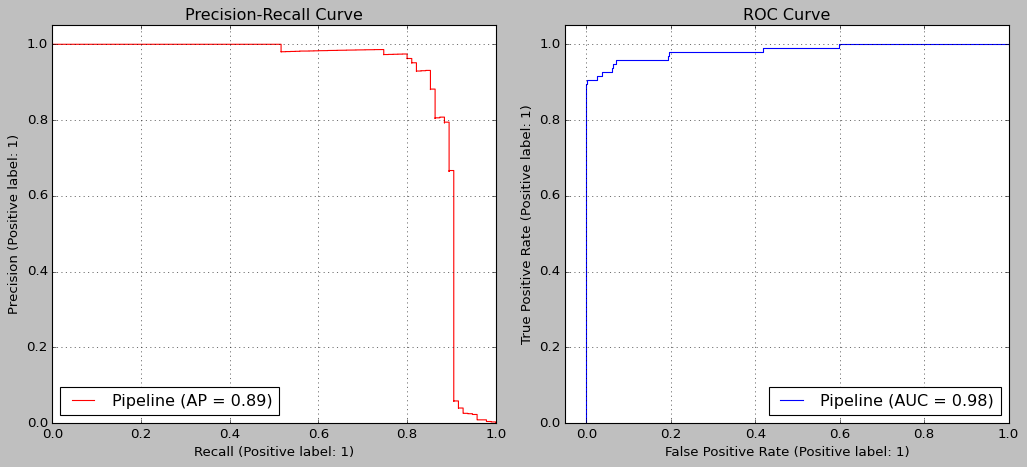

In [61]:
plt.style.use('classic')
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13, 6))

pr_disp = PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, color='r', ax=ax1)
roc_disp = RocCurveDisplay.from_estimator(best_model, X_test, y_test, color='b', ax=ax2)

pr_disp.ax_.set_title('Precision-Recall Curve')
roc_disp.ax_.set_title('ROC Curve')

ax1.grid(True)
ax2.grid(True)
ax1.set_ylim(0,1.05)
ax2.set_xlim(-0.05,1)
ax2.set_ylim(0,1.05)

plt.tight_layout()
plt.show()

**We can use this model with the appropriate threshold value set by us for getting the needed precision and recall values**
> Lets see the precision-recall values and the confusion matrix for some commonly used threshold values for this model

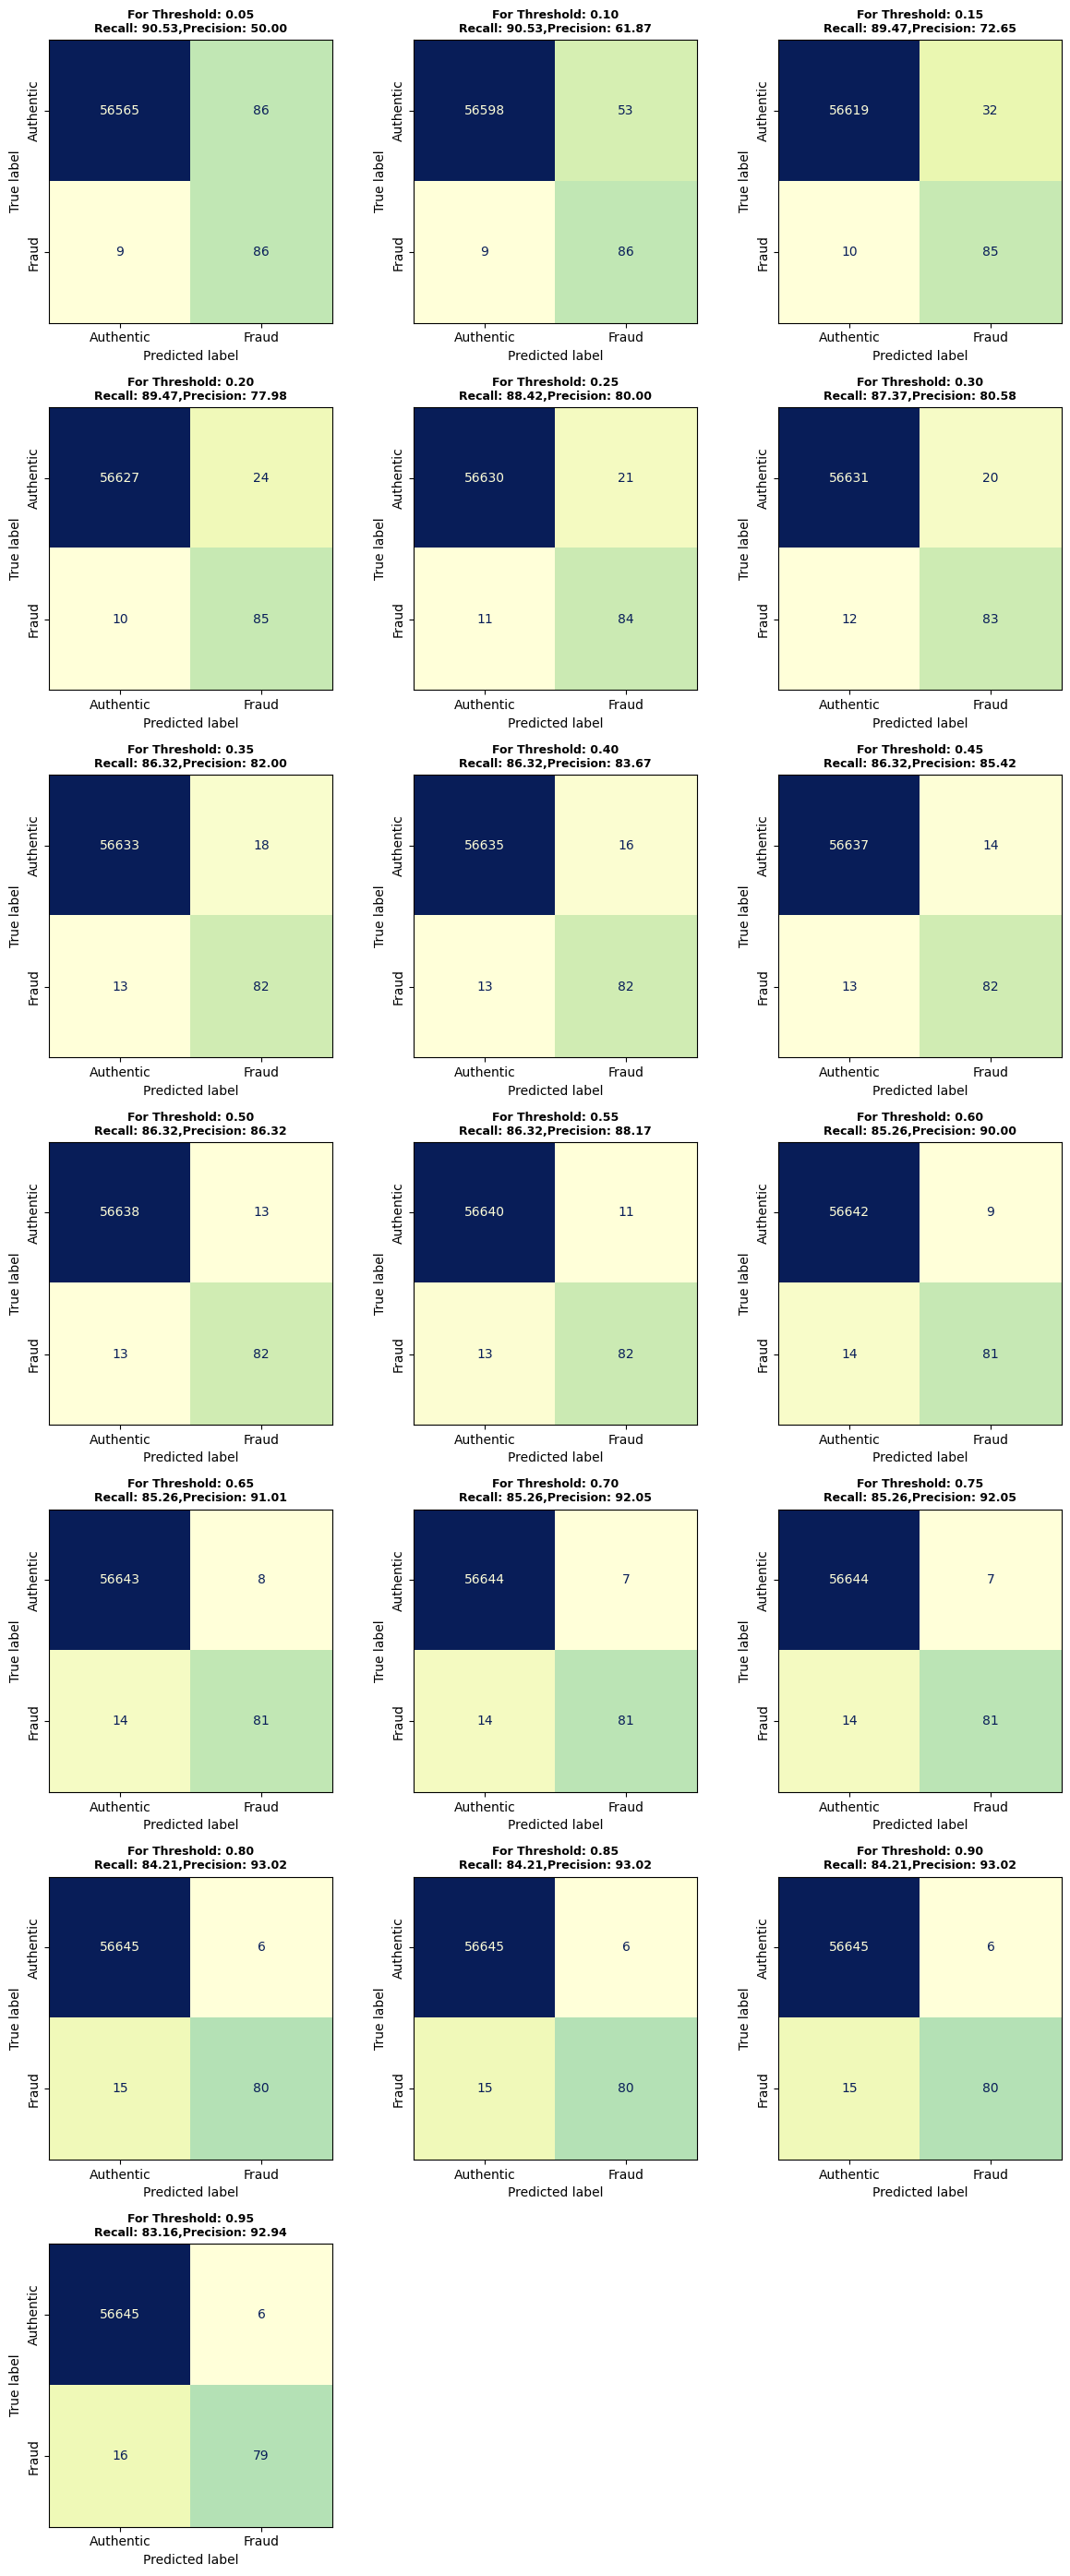

In [75]:
thresholds = np.arange(0.05, 1.0, step=0.05)
ncol = 3; nrow = int(np.ceil(len(thresholds) / ncol))

plt.style.use('default')
plt.figure(figsize=(4*ncol, 4*nrow))
for idx, threshold in enumerate(thresholds):
    
    ax = plt.subplot(nrow, ncol, idx+1)
    
    y_pred = (y_probs >= threshold).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, 
                                                         cmap='YlGnBu', ax=ax)
    
    cm_display.ax_.set_title(f'For Threshold: {threshold:.2f}\nRecall: {recall*100:.2f},'
                             f'Precision: {precision*100:.2f}', fontsize=9, fontweight='bold')
    cm_display.im_.set_norm(LogNorm(vmax=cm_display.confusion_matrix.max(),
                                    vmin=max(cm_display.confusion_matrix.min(),1e-10)))
    cm_display.im_.colorbar.remove()
    
    for label in cm_display.ax_.get_yticklabels():
        label.set_verticalalignment('center')
        label.set_rotation(90)

plt.tight_layout()
plt.show()

___